I copy-pasted the code given in canonical ensemble.ipynb here to adjust it here to solve the problem, I have defined a function (MC_1Dgas) taking arguments N=nwalkers and Temp=temperature and MCsteps_to_equilibrium, I also cancelled the declaration of T as a global variable.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

def MC_1Dgas(N,Temp,MCsteps_to_equilibrium):
    nwalkers = N
    v = np.zeros(nwalkers)
    v.fill(20)
    T = Temp
    

    def metropolis(vold,T):
        delta = 5
        vtrial = np.random.random()    
        vtrial = vold+(2*vtrial-1)*delta
        weight = np.exp(-(vtrial**2-vold**2)/T)
        vnew = vold
        if(weight >= 1): #Accept
            vnew = vtrial
        elif(weight != 0):
            r = np.random.random()
            if(r <= weight): #Accept
                vnew = vtrial
        return vnew

    # Warmup loop

    Nwarmup = MCsteps_to_equilibrium
    Ewarmup = np.zeros(Nwarmup)

    Naccept = 0.
    for j in range(Nwarmup):
        for i in range(nwalkers):
            vold = v[i]
            v[i] = metropolis(v[i],T)
            if(v[i] != vold):
                Naccept += 1
        
        Ewarmup[j] = np.sum(v**2)/nwalkers

    x = np.arange(0,Nwarmup,1)
#    pyplot.plot(x,Ewarmup,ls='-',c='blue');


#   print("Acceptance ratio= ", Naccept/float(Nwarmup*nwalkers))

    # Measurement loop

    Nmeasure = 100000
    Naccept = 0.
    E = 0.
    E2 = 0.
    for j in range(Nmeasure):
        for i in range(nwalkers):
            vold = v[i]
            v[i] = metropolis(v[i],T)
            if(v[i] != vold):
                Naccept += 1

        E += np.sum(v**2)
        E2 += np.sum(v**4)

    E = E/Nmeasure/nwalkers
    E2 = E2/Nmeasure/nwalkers
#    print("<Energy>=", E)
#    print("<Energy^2>=", E2)
#    print("Error=", np.sqrt((E2-E**2)/Nmeasure/nwalkers))

#    print("Acceptance ratio= ", Naccept/float(Nmeasure*nwalkers))
        
    return(E,E2)

# Item 4) mean energy per particle for T=10,100,400:

In [2]:
E=np.zeros(3)
E2=np.zeros(3)
Temperature=[10,100,400]
for i in range(len(Temperature)):
    (e,e2)=MC_1Dgas(20,Temperature[i],100)
    E[i]=e
    E2[i]=e2


In [3]:
E #this array is the energy per particle for the given temperatures (10,100,400)

array([  4.991346  ,  49.93965684, 199.68065369])

the previous calculations were held with the number of warmup steps to equilibrium = 100, we investigate how this number 
changes with Temperature, by varying it until the difference in the mean energy per particle in each trial is below some
threshold epsilon, epsilon is chosen to = 0.2 (to make the convergence fast, when I tried 0.05 it took so long), and we start by 5 warmup steps and increment by 5 each time until the condition of convergence is satisfied:

In [4]:
def investigate_Nwarmup(N,T):
    
    E_variedwithNwarmup=[]
    epsilon=0.2
    (e,e2)=MC_1Dgas(N,T,5)
    E_variedwithNwarmup.append(e)
    (e,e2)=MC_1Dgas(N,T,10)
    E_variedwithNwarmup.append(e)
    i=1
    while (np.abs(E_variedwithNwarmup[i]-E_variedwithNwarmup[i-1])>epsilon):
        i+=1
        (e,e2)=MC_1Dgas(N,T,5+5*i)
        E_variedwithNwarmup.append(e)
        
        
    return 10+5*i
        


In [5]:
MCsteps_to_equilibrium=[]
for t in Temperature:
    Nwarmup=investigate_Nwarmup(20,t)
    MCsteps_to_equilibrium.append(Nwarmup)

In [6]:
MCsteps_to_equilibrium

[15, 15, 25]

to investigate the dependence of Nwarmup on N(number of atoms):  

In [7]:
Nwarmup1=investigate_Nwarmup(10,100)
Nwarmup2=investigate_Nwarmup(40,100)

In [8]:
print(' for N=10, Nwarmup=',Nwarmup1,'\n','for N=40, Nwarmup=',Nwarmup2)

 for N=10, Nwarmup= 30 
 for N=40, Nwarmup= 15


the number of MCsteps needed for equilibration for N=10 is larger than the case N=40, this makes sense since it is easier
for the larger system to equilibrate more quickly.

# Item 5): the probability P(E)dE for the system of N particles to have a total energy between E and E+dE : 

total Energy E = Number of particles * mean energy per particle, we choose N=20, T=10, Nwarmup=100 and dE=1,
We need to adjust the MC_1Dgas function to return the total Energy array at each MCstep, and from this large array we would be able to calculate the propabilities:

In [9]:
def MC_1Dgas_givesEarray(N,Temp,MCsteps_to_equilibrium):
    nwalkers = N
    v = np.zeros(nwalkers)
    v.fill(20)
    T = Temp
    

    def metropolis(vold,T):
        delta = 5
        vtrial = np.random.random()    
        vtrial = vold+(2*vtrial-1)*delta
        weight = np.exp(-(vtrial**2-vold**2)/T)
        vnew = vold
        if(weight >= 1): #Accept
            vnew = vtrial
        elif(weight != 0):
            r = np.random.random()
            if(r <= weight): #Accept
                vnew = vtrial
        return vnew

    # Warmup loop

    Nwarmup = MCsteps_to_equilibrium
    Ewarmup = np.zeros(Nwarmup)

    Naccept = 0.
    for j in range(Nwarmup):
        for i in range(nwalkers):
            vold = v[i]
            v[i] = metropolis(v[i],T)
            if(v[i] != vold):
                Naccept += 1
        
        Ewarmup[j] = np.sum(v**2)/nwalkers

    x = np.arange(0,Nwarmup,1)
#    pyplot.plot(x,Ewarmup,ls='-',c='blue');


#   print("Acceptance ratio= ", Naccept/float(Nwarmup*nwalkers))

    # Measurement loop

    Nmeasure = 100000
    Naccept = 0.
    E = 0.
    E2 = 0.
    Earray=[]
    for j in range(Nmeasure):
        for i in range(nwalkers):
            vold = v[i]
            v[i] = metropolis(v[i],T)
            if(v[i] != vold):
                Naccept += 1
        
        E += np.sum(v**2)
        E2 += np.sum(v**4)
        Earray.append(np.sum(v**2))

    E = E/Nmeasure/nwalkers
    E2 = E2/Nmeasure/nwalkers
    
#    print("<Energy>=", E)
#    print("<Energy^2>=", E2)
#    print("Error=", np.sqrt((E2-E**2)/Nmeasure/nwalkers))

#    print("Acceptance ratio= ", Naccept/float(Nmeasure*nwalkers))
        
    return(E,E2,Earray)

In [10]:
(e,e2,Earray)=MC_1Dgas_givesEarray(20,10,100)

In [11]:
len(Earray)

100000

making a histogram of number of occurances, and dividing by len(Earray) to get the probabilities:

In [12]:
import math
dE=1
mx=np.max(Earray)
mn=np.min(Earray)
Nofbins=int((math.floor(mx)-math.floor(mn))/dE)
Prob=np.zeros(Nofbins)

for x in Earray:
        i=math.floor((x-mn)/dE)            # this loop populates the bins in the histogram
        Prob[i-1] +=1
    
for i in range(Nofbins):
    Prob[i]=Prob[i]/len(Earray)         # normalizing to get the probabilites

In [13]:
Erange=range(math.floor(mn),math.floor(mx),dE)

Text(0,0.5,'Probability')

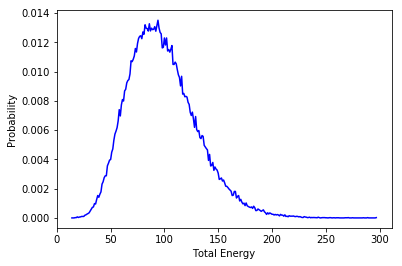

In [14]:
pyplot.plot(Erange,Prob,ls='-',c='blue');
pyplot.xlabel('Total Energy')
pyplot.ylabel('Probability')

the probabilites follow a nearly exponential decay trend from total E =100, I doubt that the lower energies are artifacts
due to the limited number of MCsteps, I expect that they will decrease furthur in probability for larger number of MCsteps

/home/asem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'ln(Probability)')

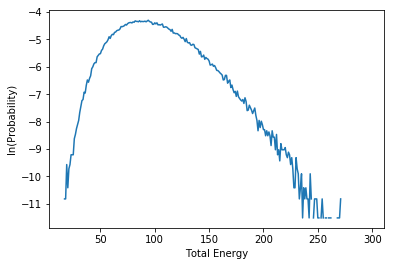

In [15]:
lnProb=np.zeros(Nofbins)
for i in range(Nofbins):
    lnProb[i]=np.log(Prob[i])

pyplot.plot(Erange,lnProb)
pyplot.xlabel('Total Energy')
pyplot.ylabel('ln(Probability)')

the plot shows a straight line in the range E =100 to E=250

# Item 6): Compute the mean energy for T from 10 to 110 & evaluate Cv per particle:

In [16]:
Temp = range(10,120,10)  # this gives the wanted range

In [17]:
E=[]
E2=[]

for t in Temp:
    (e,e2)=MC_1Dgas(20,t,100)
    E.append(e)
    E2.append(e)

In [18]:
E

[5.000481353725761,
 10.008414896756458,
 15.071172995970423,
 19.98523998867028,
 24.973972051130694,
 29.977645914573987,
 35.01649459489141,
 39.847194576526235,
 45.145878075631586,
 49.686457401717036,
 54.94085945403066]

Evaluate Cv based on energy differences, and divide by 10 which is the Temperature differences:

In [19]:
Cv=np.zeros(10)
for i in range(10):
    Cv[i]=(E[i+1]-E[i])/10
Cv

array([0.50079335, 0.50627581, 0.4914067 , 0.49887321, 0.50036739,
       0.50388487, 0.48307   , 0.52986835, 0.45405793, 0.52544021])

it can be seen that Cv = 0.5, which is expected from the equipartition theorem of an ideal gas in 1D: Cv=0.5*KB

# Item 7): calculating Cv from energy fluctuations: 

for T=10 & T=40: 

In [20]:
E2[0]-(E[0])**2

-20.00433241523326

In [21]:
E2[3]-(E[3])**2

-379.42457741607535

In [22]:
print(' for T=10, Cv =',(E2[0]-(E[0])**2)/10**2,'\n','for T=40, Cv =',(E2[3]-(E[3])**2)/40**2)

 for T=10, Cv = -0.2000433241523326 
 for T=40, Cv = -0.23714036088504709


the magnitude of both Cv is around 0.2, which is of the same order of magnitude as the expected value of 0.5, the 
discrepancy could be due to the small number of particles in the simulation or the finiteness of the number of 
MCsteps